# Churn Demo - Python API

The purpose of the demo is to show a sample of ML capabilities in Viya VDMML using the jupyter interface. We create a **ML pipeline to train and compare models for churn detection**.

In this demo we will
1. Prepare Notebook for Analysis
2. Simple Data Manipulation steps to show SQL capabilities
3. Build Classification models (Logistic Regression, Random Forest and Gradient Boosting)
4. Score Data
5. Compare Model Performance
6. Model Deployment

## 1. Prepare Notebook for Analysis

Load Packages

In [1]:
#Load Packages
import swat,_config,pygal
from swat.render import render_html
swat.options.cas.print_messages=False
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from matplotlib import pyplot as plt
from IPython.display import HTML
%matplotlib inline
import collections
from ggplot import *

Server Connection

In [2]:
user,pswd = _config.login()
host='gtpviyaea12.unx.sas.com'
portnum=5570
s = swat.CAS(host,portnum,user,pswd)

#Load Actionsets
actions = ['fedSql','sampling','regression','decisionTree','astore']
for i in actions: s.loadactionset(i)

Load Data into Memory

In [3]:
DMLib = s.table.addCaslib('DMlib', datasource = 'path', path = '/viyafiles/ankram/Data')
inMem = s.table.loadTable('churn.csv', casOut = 'churn');

#Create link to data
churn = inMem.casTable

Check out the Columns

In [4]:
for i in churn.columns: print(i)

Account_Length
VMail_Message
Day_Mins
Eve_Mins
Night_Mins
Intl_Mins
CustServ_Calls
Churn
Intl_Plan
VMail_Plan
Day_Calls
Day_Charge
Eve_Calls
Eve_Charge
Night_Calls
Night_Charge
Intl_Calls
Intl_Charge
State
Area_Code
Phone


See the First Few Rows

In [5]:
churn[churn.columns[:10]].head()

,Account_Length,VMail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,VMail_Plan
0,128.00,25.00,265.10,197.40,244.70,10.00,1.00,0.00,0.00,1.00
1,107.00,26.00,161.60,195.50,254.40,13.70,1.00,0.00,0.00,1.00
2,137.00,0.00,243.40,121.20,162.60,12.20,0.00,0.00,0.00,0.00
3,84.00,0.00,299.40,61.90,196.90,6.60,2.00,0.00,1.00,0.00
4,75.00,0.00,166.70,148.30,186.90,10.10,3.00,0.00,1.00,0.00


## 2. Simple Data Manipulation

Let's Check out out the data types associated with each column

In [6]:
churn.dtypes

Account_Length     double
VMail_Message      double
Day_Mins           double
Eve_Mins           double
Night_Mins         double
Intl_Mins          double
CustServ_Calls     double
Churn              double
Intl_Plan          double
VMail_Plan         double
Day_Calls          double
Day_Charge         double
Eve_Calls          double
Eve_Charge         double
Night_Calls        double
Night_Charge       double
Intl_Calls         double
Intl_Charge        double
State             varchar
Area_Code          double
Phone             varchar
dtype: object

We notice two things that ought to be done here. The data type for `churn` and `area_code` variables should not be double. Let's change that by using some SQL on the in memory table. 

In [7]:
#programmatically build query
col_list= [i for i in churn.columns if i not in ('Area_Code','Intl_Plan','Churn','VMail_Plan')]
cas_lib='DMlib'
option_params='{options replace=true}'
query = '''CREATE TABLE {}.churn {} AS 
           SELECT {}, 
                  CAST(intl_plan as char) AS intl_plan,
                  CAST(vmail_plan as char) AS vmail_plan,
                  CAST(area_code as varchar) AS area_code,
                  CAST(churn as varchar) AS churn
            FROM DMlib.churn'''.format(cas_lib,
                              option_params,
                              col_list).replace('[','').replace(']','').replace("'",'')
print(query)

CREATE TABLE DMlib.churn {options replace=true} AS 
           SELECT Account_Length, VMail_Message, Day_Mins, Eve_Mins, Night_Mins, Intl_Mins, CustServ_Calls, Day_Calls, Day_Charge, Eve_Calls, Eve_Charge, Night_Calls, Night_Charge, Intl_Calls, Intl_Charge, State, Phone, 
                  CAST(intl_plan as char) AS intl_plan,
                  CAST(vmail_plan as char) AS vmail_plan,
                  CAST(area_code as varchar) AS area_code,
                  CAST(churn as varchar) AS churn
            FROM DMlib.churn


In [8]:
#execute query and check the results
s.fedSQL.execDirect(query) 

churn[['area_code','churn','intl_plan','vmail_plan']].head()

,AREA_CODE,CHURN,INTL_PLAN,VMAIL_PLAN
0,415,0,0,1
1,415,0,0,1
2,415,0,0,0
3,408,0,1,0
4,415,0,1,0


In [9]:
#Validate Column Types
churn[['area_code','churn','intl_plan','vmail_plan']].dtypes

AREA_CODE     varchar
CHURN         varchar
INTL_PLAN        char
VMAIL_PLAN       char
dtype: object

In [10]:
# To save the file to the filesystem
#s.table.save(table='CHURN', name='churn_opt.csv')

Next we can do a quick exploration by performing group-bys

In [11]:
grpsumm=churn.groupby('churn').summary()
comb_group_summ = grpsumm.concat_bygroups()
combined_summary = comb_group_summ['Summary']
combined_summary.sort_values(by=['Column'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
CHURN,,,,,,,,,,,,,,,
0,Account_Length,1.00,243.00,2850.00,0.00,100.79,287262.00,39.88,0.75,1590.60,33485820.00,4531624.69,39.57,134.92,0.00
1,Account_Length,1.00,225.00,483.00,0.00,102.66,49587.00,39.47,1.80,1557.71,5841645.00,750815.66,38.44,57.17,0.00
1,CustServ_Calls,0.00,9.00,483.00,0.00,2.23,1077.00,1.85,0.08,3.43,4057.00,1655.49,83.11,26.44,0.00
0,CustServ_Calls,0.00,8.00,2850.00,0.00,1.45,4132.00,1.16,0.02,1.35,9850.00,3859.32,80.28,66.50,0.00
1,Day_Calls,0.00,165.00,483.00,0.00,101.34,48945.00,21.58,0.98,465.80,5184375.00,224513.66,21.30,103.19,0.00
0,Day_Calls,0.00,163.00,2850.00,0.00,100.28,285807.00,19.80,0.37,392.09,29778681.00,1117052.49,19.75,270.37,0.00
0,Day_Charge,0.00,53.65,2850.00,0.00,29.78,84874.20,8.53,0.16,72.78,2734925.83,207336.41,28.65,186.36,0.00
1,Day_Charge,0.00,59.64,483.00,0.00,35.18,16989.97,11.73,0.53,137.59,663954.35,66316.50,33.35,65.91,0.00
0,Day_Mins,0.00,315.60,2850.00,0.00,175.18,499250.90,50.18,0.94,2518.20,94631000.61,7174347.57,28.65,186.36,0.00


Or, if you prefer visually scanning through data here's an example of a neat plot for visualization or you could simply get a pandas barplot

In [12]:
radar_chart=pygal.Radar(style=pygal.style.DefaultStyle,include_x_axis=False)
radar_chart.title='Quick Feature Comparison - By Group Differences - Sq.Logged Mean Values'
radar_chart.x_labels=sorted(list(combined_summary['Column'].unique()))
radar_chart.add('Non-Churners',list(round(np.log(grpsumm['ByGroup1.Summary'][['Column','Mean']]
                                    .sort_values(by=['Column'])['Mean'])**2,1)))
radar_chart.add('Churners',list(round(np.log(grpsumm['ByGroup2.Summary'][['Column','Mean']]
                                    .sort_values(by=['Column'])['Mean'])**2,1)))
radar_chart.render_to_file('radar.svg')
HTML('<iframe width=800 height=800 frameBorder=0 src=radar.svg></iframe>')

## 3. Build Classificaiton Models

Perform a stratified sample of the data

In [13]:
#Conduct Sampling and see the data set
s.sampling.stratified(
  table=dict(name = "churn", groupBy = "churn"),
  output=dict(casOut = dict(name = "churn_part", replace = True), copyVars = "ALL"),
  samppct=70,
  partind=True
)

cpart = s.CASTable('churn_part')
cpart[cpart.columns[10:]].head()

,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Phone,INTL_PLAN,VMAIL_PLAN,AREA_CODE,CHURN,_PartInd_
0,16.78,91.00,11.01,3.00,2.70,KS,382-4657,0,1,415,0,1.00
1,16.62,103.00,11.45,3.00,3.70,OH,371-7191,0,1,415,0,1.00
2,10.30,104.00,7.32,5.00,3.29,NJ,358-1921,0,0,415,0,1.00
3,5.26,89.00,8.86,7.00,1.78,OH,375-9999,1,0,408,0,1.00
4,12.61,121.00,8.41,3.00,2.73,OK,330-6626,1,0,415,0,1.00


Create variable shortcuts to aid us in our modeling

In [14]:
#Variable Shortcuts
numeric_inputs = [i for i in cpart.dtypes[cpart.dtypes=='double'].index if i!='_PartInd_']
class_inputs = [i for i in cpart.dtypes[(cpart.dtypes =='varchar') |(cpart.dtypes =='char')].index if (i!='Phone') & (i!='CHURN')] 
all_inputs = class_inputs + numeric_inputs
target = 'churn'

print(class_inputs)

#Keyword Shortcuts for Modeling
params = dict(
    table = dict(name="churn_part", where = '_partind_ = 1'),
    target = target,
    inputs = all_inputs,
    nominals = class_inputs)

models = collections.OrderedDict()
models['rf']  = 'Random Forest'
models['gbt'] = 'Gradient Boosting'
models['lr']  = 'Logistic Regression'

['State', 'INTL_PLAN', 'VMAIL_PLAN', 'AREA_CODE']


**Random Forest Model**

In [15]:
r_forest = s.decisiontree.foresttrain(**params, casout=dict(name="rf_model", replace=True),
                                       savestate=dict(name='forest_model_train', replace=True), vote="PROB",
                                     maxLevel=20, M=4, ntree=100)

render_html(r_forest)

Forest for CHURN_PART 
 Descr 
 Value 
 
 
 Number of Trees 100 
 Number of Selected Variables (M) 4 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 19 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 169 
 Min Number of Tree Nodes 83 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 20 
 Min Number of Levels 19 
 Max Number of Leaves 85 
 Min Number of Leaves 42 
 Maximum Size of Leaves 987 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) nan 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 DMlib rf_model 13170 124 CASTable('rf_model', caslib='DMlib')

**Gradient Boosting**

In [16]:
gbt = s.decisionTree.gbtreeTrain(**params, seed = 1, casOut = dict(name = 'gbt_model', replace = True), ntree=50)

render_html(gbt)

Gradient Boosting Tree for CHURN_PART 
 Descr 
 Value 
 
 
 Number of Trees 50 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 19 
 Number of Bins 20 
 Number of Variables 19 
 Max Number of Tree Nodes 59 
 Min Number of Tree Nodes 35 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 30 
 Min Number of Leaves 18 
 Maximum Size of Leaves 735 
 Minimum Size of Leaves 5 
 Random Number Seed 1 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 DMlib gbt_model 2580 111 CASTable('gbt_model', caslib='DMlib')

**Logistic Regression**

In [17]:
#Many of those keyword arguments passed are optional to show flexibility
log_reg = cpart.logistic(class_=[dict(vars=class_inputs)],
                                   model={"depvars":[{"name":"churn", "options":{"event":"1"}}],
                                        "effects":[dict(vars=all_inputs)]
                                         },
                                   partbyvar={"name": "_partind_", "train": "1", "valid": "0"},
                                   selection=dict(method="stepwise"),
                                   output=dict(casout=dict(name="churn_scored_logistic",
                                                          replace=True),
                                              copyvars="ALL"),
                                  )
#Fix Column
s.dataStep.runCode(
  code='''data _scored_lr(replace=YES); 
          set churn_scored_logistic; 
              p_churn1=_pred_; 
              if churn = "1" then churn_numeric=1; 
                  else churn_numeric=0;
         run;'''
)

render_html(log_reg) 

Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source CHURN_PART 
 RESPONSEVAR Response Variable CHURN 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Newton-Raphson with Ridging 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Total 
 Training 
 Validation 
 
 
 NREAD Number of Observations Read 3333 2333 1000 
 NUSED Number of Observations Used 3333 2333 1000 
 
 
 
 
 Response Profile 
 Ordered Value 
 CHURN 
 CHURN 
 Total Frequency 
 Training 
 Validation 
 Probability Modeled 
 
 
 1 0 0 2850 1995 855 
 2 1 1 483 338 145 * 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 State 51 AK AL AR AZ CA CO CT DC DE FL GA HI IA ID IL IN KS KY LA MA MD ME MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT WA WI WV WY 
 INTL_PLAN 2 0 1 
 VMAIL_PLAN 2 0 1 
 AREA_CODE 3 408 415 510 
 
 
 
 
 Selection Information 
 Description 
 Value 
 Numeric Value 
 
 
 Selection Method Stepwise nan 
 Select Criterion SBC nan 
 Stop Criterion SBC nan 
 Effect Hierarchy Enforced None nan 
 Stop Horizon 3 3 
 
 
 
 
 Convergence Status 
 Reason 
 Status 
 Max Gradient 
 
 
 Convergence criterion (GCONV=1E-8) satisfied. 0 5.9004409E-9 
 
 
 
 
 Selection Summary 
 Control 
 Step 
 Effect Entered 
 Effect Removed 
 Number Of Effects 
 SBC 
 Optimal SBC 
 
 
 0 Intercept 1 1938.1738902 0 
 - 1 INTL_PLAN 2 1789.0246873 0 
 2 Day_Mins 3 1725.2848987 0 
 3 CustServ_Calls 4 1613.8388115 0 
 4 VMAIL_PLAN 5 1591.9196597 0 
 5 Eve_Mins 6 1568.6966104 0 
 6 Intl_Charge 7 1560.5298477 1 
 
 
 
 
 Stop Reason 
 Reason 
 Code 
 
 
 Stepwise selection stopped because adding or removing an effect does not improve the SBC criterion. 8 
 
 
 
 
 Selection Reason 
 Reason 
 
 
 The model at step 6 is selected. 
 
 
 
 
 Selected Effects 
 Label 
 Effects 
 
 
 Selected Effects: Intercept INTL_PLAN VMAIL_PLAN Day_Mins Eve_Mins CustServ_Calls Intl_Charge 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 9 
 NEFFECTS Number of Effects 7 
 MAXEFCOLS Max Effect Columns 2 
 DESIGNRANK Rank of Design 7 
 OPTPARM Parameters in Optimization 7 
 
 
 
 
 Likelihood Ratio Test 
 Test 
 DF 
 Chi-Square 
 Pr > ChiSq 
 
 
 Likelihood Ratio 6 424.39598724 1.585361E-88 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Training 
 Validation 
 
 
 M2LL -2 Log Likelihood 1506.0229927 688.37103201 
 AIC AIC (smaller is better) 1520.0229927 702.37103201 
 AICC AICC (smaller is better) 1520.0711647 702.48393524 
 SBC SBC (smaller is better) 1560.3073646 736.72531897 
 ASE Average Square Error 0.0983064769 0.10384736 
 M2LLNULL -2 Log L (Intercept-only) 1930.4189799 827.87426078 
 RSQUARE R-Square 0.1663236168 0.1302097851 
 ADJRSQ Max-rescaled R-Square 0.2955113448 0.2312691155 
 MCFADDEN McFadden's R-Square 0.2198465678 0.1685077498 
 MISCLASS Misclassification Rate 0.1380197171 0.135 
 DIFFMEAN Difference of Means 0.2105654679 0.1852280358 
 
 
 
 
 Parameter Estimates 
 Effect 
 INTL_PLAN 
 VMAIL_PLAN 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Intercept Intercept 1 -7.130010826 0.5603305004 161.91677778 4.313905E-37 
 INTL_PLAN 0 INTL_PLAN 0 INTL_PLAN_0 1 -1.956321355 0.173224085 127.54511789 1.411552E-29 
 INTL_PLAN 1 INTL_PLAN 1 INTL_PLAN_1 0 0 nan nan nan 
 VMAIL_PLAN 0 VMAIL_PLAN 0 VMAIL_PLAN_0 1 1.1209165895 0.1770185194 40.096751192 2.416906E-10 
 VMAIL_PLAN 1 VMAIL_PLAN 1 VMAIL_PLAN_1 0 0 nan nan nan 
 Day_Mins Day_Mins Day_Mins 1 0.0142031783 0.0013038988 118.65424982 1.246721E-27 
 Eve_Mins Eve_Mins Eve_Mins 1 0.007157186 0.001354609 27.916226876 1.266829E-7 
 CustServ_Calls CustServ_Calls CustServ_Calls 1 0.5023935972 0.0474803943 111.95914081 3.647504E-26 
 Intl_Charge Intl_Charge Intl_Charge 1 0.3552710914 0.0903718086 15.454458488 0.0000845173 
 
 
 
 
 Task Timing 
 RowId 
 Task 
 Time 
 Relative Time 
 
 
 SETUP Setup and Parsing 0.0170931816 0.0338167441 
 LEVELIZATION Levelization 

Helper function for model assessment - it generates and collects the validation metrics

## 4. Score Models

Auxiliary function to help score

In [18]:
def score_model(model):
    score = dict(
        table      = "churn_part",
        modelTable = model + '_model',
        copyVars   = [target, '_partind_'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )
    return score

Score Models

In [19]:
# Decision Tree
s.decisionTree.forestScore(**score_model('rf'))

# Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))

#Logistic already scored
s.CASTable('_scored_lr').head()

,_PRED_,Account_Length,VMail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Day_Calls,Day_Charge,...,Intl_Charge,State,Phone,INTL_PLAN,VMAIL_PLAN,AREA_CODE,CHURN,_PartInd_,p_churn1,churn_numeric
0,0.08,128.00,25.00,265.10,197.40,244.70,10.00,1.00,110.00,45.07,...,2.70,KS,382-4657,0,1,415,0,1.00,0.08,0.00
1,0.03,107.00,26.00,161.60,195.50,254.40,13.70,1.00,123.00,27.47,...,3.70,OH,371-7191,0,1,415,0,1.00,0.03,0.00
2,0.08,137.00,0.00,243.40,121.20,162.60,12.20,0.00,114.00,41.38,...,3.29,NJ,358-1921,0,0,415,0,1.00,0.08,0.00
3,0.58,84.00,0.00,299.40,61.90,196.90,6.60,2.00,71.00,50.90,...,1.78,OH,375-9999,1,0,408,0,1.00,0.58,0.00
4,0.47,75.00,0.00,166.70,148.30,186.90,10.10,3.00,113.00,28.34,...,2.73,OK,330-6626,1,0,415,0,1.00,0.47,0.00


Standardize prediction column

In [20]:
for i in range(len(models)-1):
    s.dataStep.runCode('''
            data _scored_''' + list(models)[i] + '''; 
                set _scored_''' + list(models)[i] + '''; 
                if _''' + list(models)[i] + '''_predname_ = "1"
                    then p_''' + target + '''1 = _''' + list(models)[i] + '''_predp_; 
                    else p_''' + target + '''1 = 1 - _''' + list(models)[i] + '''_predp_;
                    if churn = "1" then churn_numeric=1; else churn_numeric=0;
            run;
        ''')

## 5. Compare Model Performance

Function to aid in assessing models

In [21]:
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_partind_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = "churn_numeric",
        event    = "1",   
    )
    return assess

Generate ROC and misclassification stats

In [22]:
# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model']  = list(models.values())[i]
    roc_df  = pd.concat([roc_df,  tmp.ROCInfo])

View Confusion Matrix

In [23]:
print('\n', 'Confusion Matrix Information'.center(42, ' '))
roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'TP', 'FP', 'FN', 'TN']].reset_index(drop = True)


        Confusion Matrix Information       


,Model,TP,FP,FN,TN
0,Random Forest,90.00,10.00,55.00,845.00
1,Gradient Boosting,74.00,17.00,71.00,838.00
2,Logistic Regression,28.00,18.00,117.00,837.00


See Misclassification Rates

In [24]:
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2)==0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
0,Random Forest,0.06
1,Gradient Boosting,0.09
2,Logistic Regression,0.14


See ROC Curve

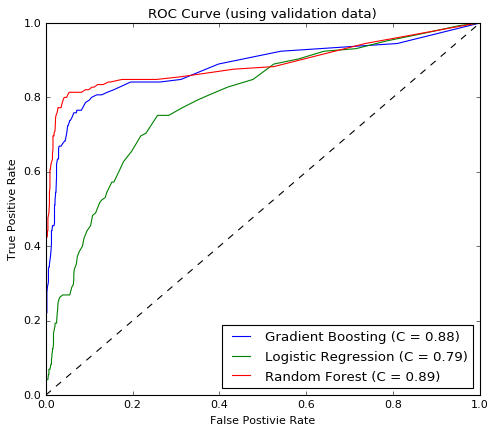

In [25]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)')
plt.show();

## 6. Deployment

Promote table into public memory so others can access in other interfaces

In [26]:
s.table.promote(name='churn',drop=True, target='churn_Andrew', targetlib='public')

+ Elapsed: 0.0103s, user: 0.003s, sys: 0.011s, mem: 0.148mb

We save our Forset Model in a binary form called ASTORE. Other users can access this model, and deploy the model in various ways:
1. In-batch: Using Code in SAS Studio via API (R, Python, Java, LUA, REST)
2. In-database: With SAS In-database technologies
3. In-stream: With SAS event stream processing
4. Over-time: Tracked with SAS Model Manager

Describe Scoring Model

In [27]:
s.astore.describe("FOREST_MODEL_TRAIN")

[Key]

 Store Key
 
                                         Key
 0  7C749B9B7C6D69037FDF8D42FFE31A7295D0A61F

[Description]

 Run Information
 
          Attribute               Value
 0  Analytic Engine              forest
 1     Time Created  29Aug2017:15:06:27

[InputVariables]

 Input Variables
 
               Name  Length    Role            Type RawType FormatName
 0            State    2.00   Input  Classification    Char           
 1        INTL_PLAN    1.00   Input  Classification    Char           
 2       VMAIL_PLAN    1.00   Input  Classification    Char           
 3        AREA_CODE    3.00   Input  Classification    Char           
 4   Account_Length    8.00   Input        Interval     Num           
 5    VMail_Message    8.00   Input        Interval     Num           
 6         Day_Mins    8.00   Input        Interval     Num           
 7         Eve_Mins    8.00   Input        Interval     Num           
 8       Night_Mins    8.00   Input        Interval     Num           
 9        Intl_Mins    8.00   Input        Interval     Num           
 10  CustServ_Calls    8.00   Input        Interval     Num           
 11       Day_Calls    8.00   Input        Interval     Num           
 12      Day_Charge    8.00   Input        Interval     Num           
 13       Eve_Calls    8.00   Input        Interval     Num           
 14      Eve_Charge    8.00   Input        Interval     Num           
 15     Night_Calls    8.00   Input        Interval     Num           
 16    Night_Charge    8.00   Input        Interval     Num           
 17      Intl_Calls    8.00   Input        Interval     Num           
 18     Intl_Charge    8.00   Input        Interval     Num           
 19           CHURN    1.00  Target  Classification    Char           

[OutputVariables]

 Output Variables
 
        Name  Length  Type               Label
 0  P_CHURN0    8.00   Num  Predicted: CHURN=0
 1  P_CHURN1    8.00   Num  Predicted: CHURN=1
 2   I_CHURN   32.00  Char         Into: CHURN
 3    _WARN_    4.00  Char            Warnings

+ Elapsed: 0.467s, user: 1.18s, sys: 0.304s, mem: 506mb

Save scoring code for others

In [28]:
s.table.save(table='FOREST_MODEL_TRAIN', caslib='DMlib',
                name ='forest_model_champ.sashdat', replace=True)

[caslib]

 'DMlib'

[name]

 'forest_model_champ.sashdat'

+ Elapsed: 0.233s, user: 0.013s, sys: 0.061s, mem: 111mb

close the connection

In [29]:
s.close()